# Composite Scores

This is a Reagent Analytics project demo, using the API, to answer questions about foreign influence in various entities in the Istio open source project.

We're specifically looking at conglomerate scores here.

In [1]:
from reagentpy import Reagent

repo = "istio/istio"
limit = 50
china_timezone = 8.0

## Forward

Currently, Reagent filters git users by timezone to determine what country they are.  This is because git does not offer finer-grained location data on users by default; when location data *is* available, it is always user-defined, and therefore unreliable.  To extrapolate country from timezone, Reagent use statistical analysis.  Timezones of interest are chosen by determining which timezones have a majority (> 60%) of their population comprised of residents of countries of interest.  Countries of interest are rigorously defined here[https://www.state.gov/countries-of-particular-concern-special-watch-list-countries-entities-of-particular-concern/].  Their timezones are as follows:

- Burma (UTC 6.5)
- People’s Republic of China (UTC 8.0)
- Cuba (UTC -4.0, -5.0)
- Eritrea (UTC 3.0)
- Iran (UTC 3.5)
- the Democratic People’s Republic of Korea (UTC 9.0)
- Nicaragua (UTC -6.0)
- Pakistan (UTC 5.0)
- Russia (UTC 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0)
- Saudi Arabia (UTC 3.0)
- Tajikistan (UTC 5.0)
- Turkmenistan (UTC 5.0)

## Foreign Adversarial Influence Score

Given a NON-OPTIONAL repository name (formatted "parent/repo_name", case-sensitive), get a HIGH-LEVEL AVERAGE SUMMARY OF timezone spoofs, potentially adversarial timezones, and non-work purpose-built accounts.

This calculation is weighted differently from the adversarial components query, since both the timezones and non-work purpose-built accounts are only potentially adversarial. Timezone spoofing requires intent to misrepresent location data, so it is weighted the most heavily. Potentially adversarial timezones and non-work purpose-built accounts are looped into this final percentage only by 1/3.

Returns the average of the timezone spoof percentage, potentially adversarial timezone percentage, and non-work purpose-built account percentage.

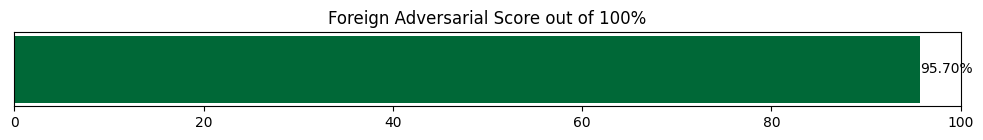

In [2]:
Reagent().boe_visualizations().total_chart(repo)

In [3]:
Reagent().composite_scores().adversarial_total(repo).df()

,foreign_adversarial_score
0,95.7


## Foreign Adversarial Score Components

Given a NON-OPTIONAL repository name (formatted "parent/repo_name", case-sensitive), get adversarial threat score info. Adversarial threat scoring is broken down by commit percentage.

“Timezone Spoofs” occur when git users deliberately modify their timezone data to mislead investigators. “Teleportation” occurs when they do this poorly, making it seem as though users teleport through space and time to commit code across the globe in mere minutes. It is difficult to manipulate metadata without detection, so we have high confidence in these numbers. We measure adversarial timezone spoofing by taking the percentage of commits that contain manufactured data.
Larger percentages of this in a repo indicate that many users are attempting to conceal their identities, which has a diversity in the nature and magnitude of consequences for open source repositories.

“Potentially Adversarial Timezones” speaks to the proportion of commits coming from timezones that correspond to potentially adversarial nations, including China, Russia, Afghanistan, Syria, Iran, Belarus, Malaysia, Myanmar, North Korea, and Zimbabwe. Specifically, we look at commits coming from UTC 3.0, 3.5, 4.5, 6.5, 8.0, and 12.0, since these are the most concentrated areas of the globe where nations of interest are located. Larger percentages of users operating in these timezones does not immediately indicate threat of any kind; rather, we recommend looking at this metric within the context of other information about the software project from Reagent and elsewhere. These open source contributors simply live in locations that are more likely to produce malicious actors than elsewhere.

"Non-Work Purpose-Built Accounts" refers to the number of user email addresses connected to the repository that are not in a known data breach, and that are hosted by one of the following free email providers:

hotmail
yahoo
gmail
googlemail
protonmail
proton
gmx
ymail
itlook
bluewin
online
web
aol
live
The utility of searching for users in data breaches is twofold:

The presence of a user's email in a known data breach provides us a place to look for additional information about the user, should that be necessary;
The absence of a user's email address in a known data breach provides us with a measure of confidence that the email is only used for one specific purpose.
A good example of a "purpose-built" email address would be a work address: an employee at a company has an email address for work, and they only use it in the context of work. Filtering out work emails aides in determining the likelihood of a user being a bot or a malicious actor, since using a purpose-built account from a free email provider is an easy way to obscure one's actual identity and remain anonymous online.
Returns timezone spoof percentage, potentially adversarial timezone percentage, and non-work purpose-built account percentage.

In [4]:
Reagent().composite_scores().adversarial_components(repo).df()

,timezone_spoofs_score,timezone_spoofs_weight,adversarial_timezones_score,adversarial_timezones_weight,purpose_built_accounts_score,purpose_built_accounts_weight
0,99.5,0.5,84.7,0.25,63.4,0.25


## Foreign Adversarial Timezones

Given a NON-OPTIONAL repository name (formatted "parent/repo_name", case-sensitive), get a list of all POTENTIALLY ADVERSARIAL timezones commits were authored or committed in within the repository, broken down by percentage.

Returns the percentage of commits by timezone and corresponding major city.

Sorted by percentage in descending order, then UTC offset.

### Foreign Adversarial Influence by Percentage

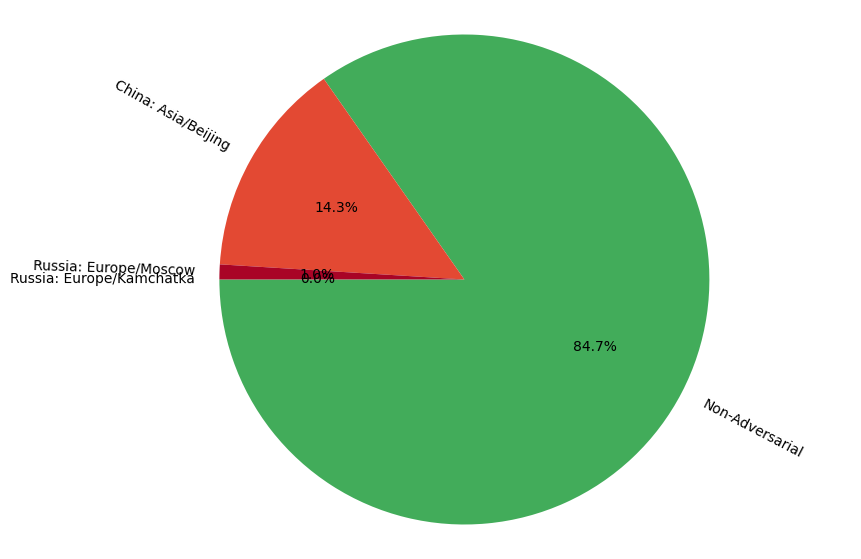

In [5]:
Reagent().boe_visualizations().plot_adversarial_percent_timezone_color(repo)

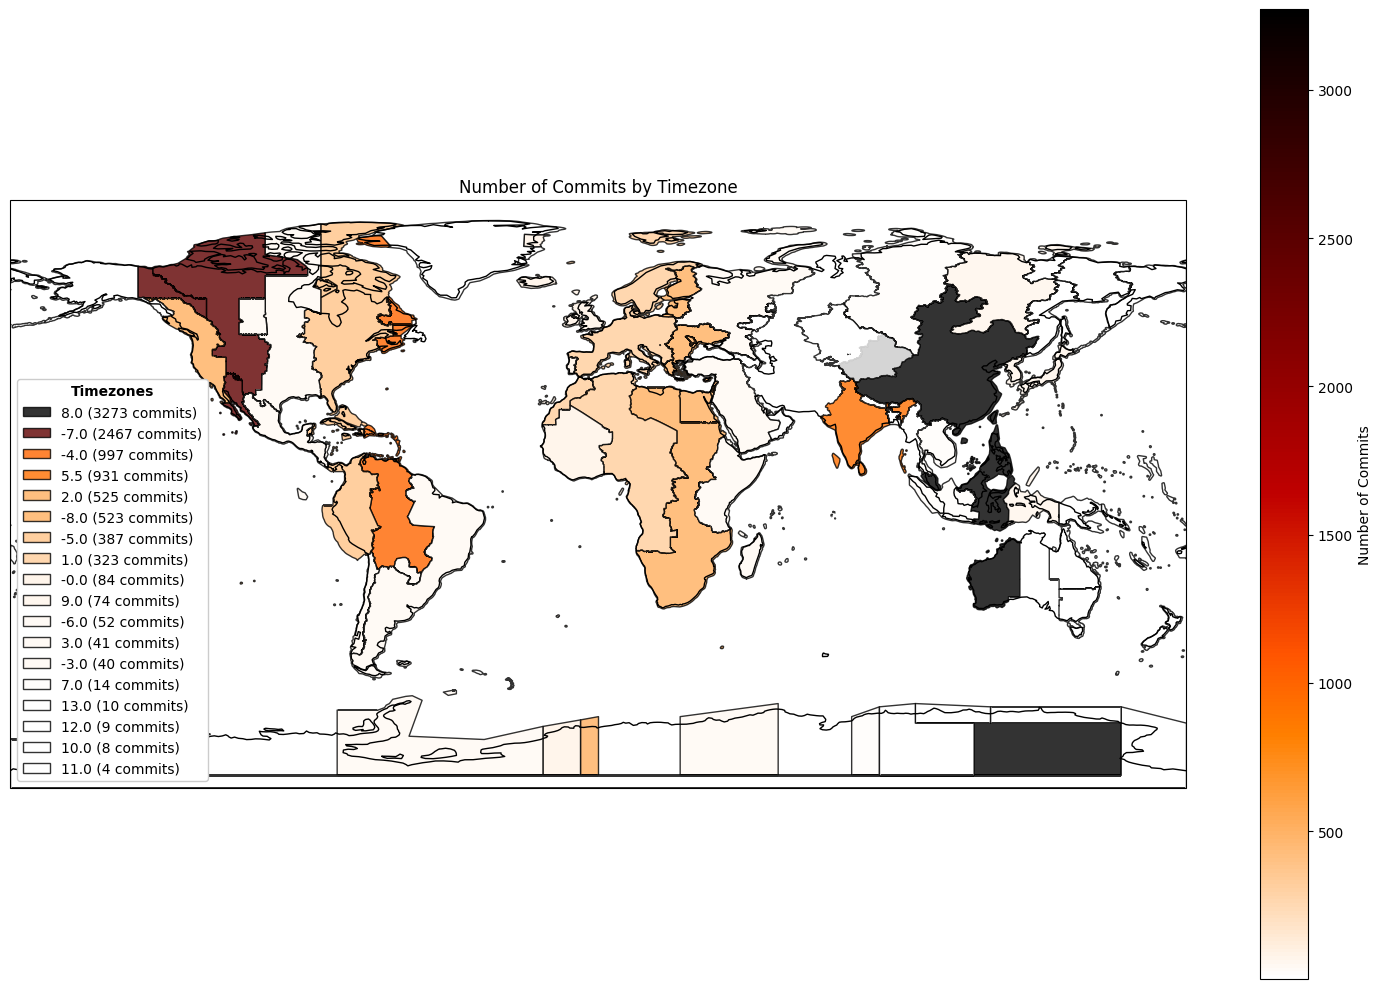

In [6]:
Reagent().timezone_visualizations().build_and_show_timezone_map(repo)

In [7]:
Reagent().composite_scores().adversarial_timezones(repo).df()

,timezone,major_city,country,percent_of_total_commits
0,NaN,Non-Adversarial,,84.726
1,8.0,Asia/Beijing,China,14.289
2,3.0,Europe/Moscow,Russia,0.957
3,12.0,Europe/Kamchatka,Russia,0.028


## Metadata Risk Score Components

Given a NON-OPTIONAL repository name (formatted "parent/repo_name", case-sensitive), get threat score info (project fragmentation, unfocused contribution, context switching, interactive churn).

Project Fragmentation is defined as the ratio of files within a repository edited by ten or more developers to files within a repository edited by less than ten developers. The significance factor for this function is r = 16, meaning that a file is sixteen times more likely to contain a vulnerability if ten or more developers have contributed to it.

Unfocused Contribution is measured by taking the average pagerank of each file within a repo. The significance factor for this function is r = .4497, meaning that vulnerabilities scale proportionally with developer multitasking (per file) with a rate of about half.

Context Switching is calculated by taking the average weekly density of distinct file communities users commit to each week.
The significance factor for this function is r = 0.17, meaning there is a small but significant correllation with vulnerabilities introduced to distinct file communities that each developer contributes to. File communities are groups of files that are typically modified together, and roughly translate to "features" or "modules" in a codebase.

Interactive Churn is the average weekly number of user interactions a file has, scaled by how recent each action is. The significance factor for this function is r = 0.16, meaning there is a small but significant correllation with vulnerability introduction to the number of lines of other peoples' code a developer edits.

Returns project fragmentation score, unfocused contribution score, context switching score, and interactive churn score, all out of ten.

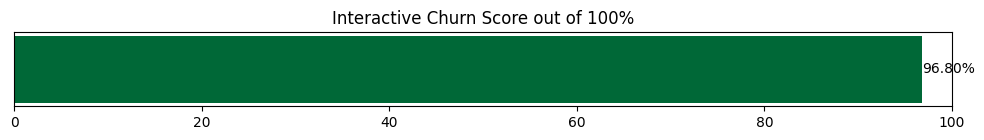

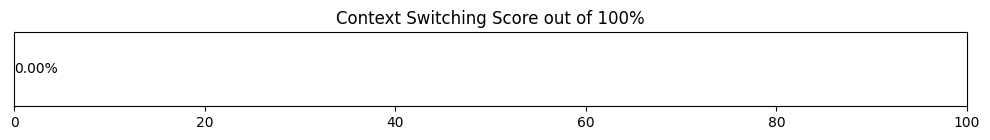

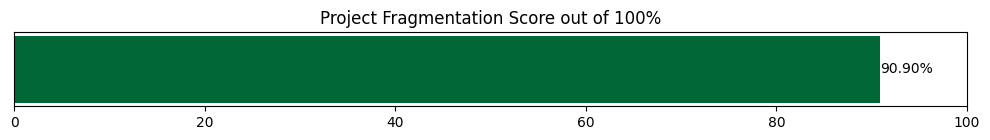

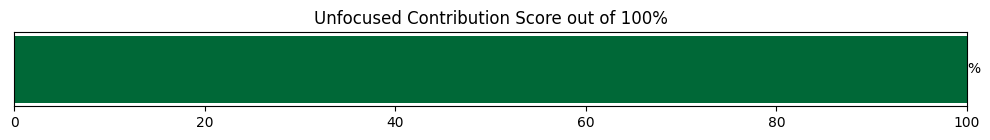

In [8]:
Reagent().boe_visualizations().create_percent_chart(repo)

In [9]:
Reagent().composite_scores().nonadversarial_components(repo).df()

,interactive_churn_score,context_switching_score,project_fragmentation_score,unfocused_contribution_score
0,96.8,0,90.9,100.0


## Metadata Risk Total

Given a NON-OPTIONAL repository name (formatted "parent/repo_name", case-sensitive), get a HIGH-LEVEL AVERAGE SUMMARY OF project fragmentation, unfocused contribution, context switching, interactive churn.

This takes the average percentages of project fragmentation, unfocused contribution, context switching, and interactive churn, and returns it as an average percent of commits to be worried about.

Calculations change when a category is "maxed out" (has a percentage of 100%), since that indicates an extraordinary level of risk in that category. In that case, the average is divided by one less than the original number of categories so the top-level percentage of risk is higher.

Returns HIGH-LEVEL AVERAGE SUMMARY OF project fragmentation, unfocused contribution, context switching, interactive churn.

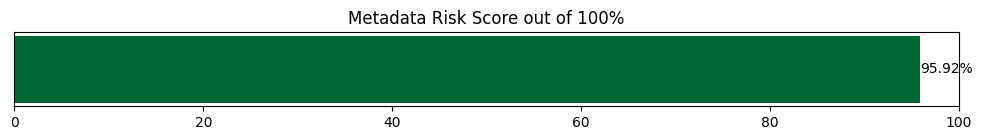

In [10]:

Reagent().boe_visualizations().total_chart(repo, adversarial=False)

In [11]:
Reagent().composite_scores().nonadversarial_total(repo).df()

,metadata_risk_score
0,95.915


## Timezones

Given a NON-OPTIONAL repository name (formatted "parent/repo_name", case-sensitive), get a list of all timezones commits were authored or committed in within the repository, broken down by percentage.

Returns the percentage of commits by timezone.

Sorted by UTC offset in ascending order.

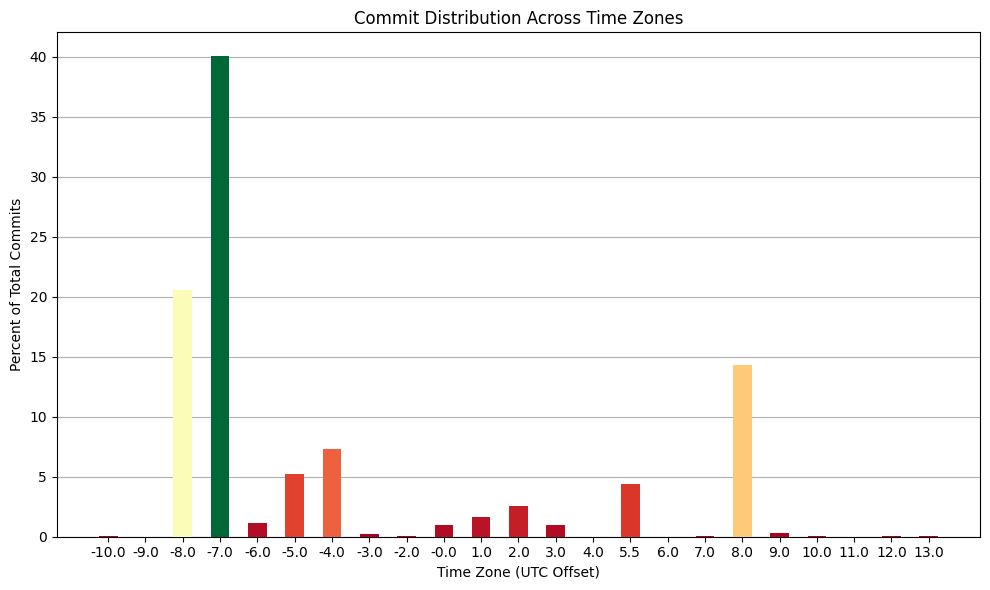

In [12]:
Reagent().boe_visualizations().plot_percent_timezone_color(repo)

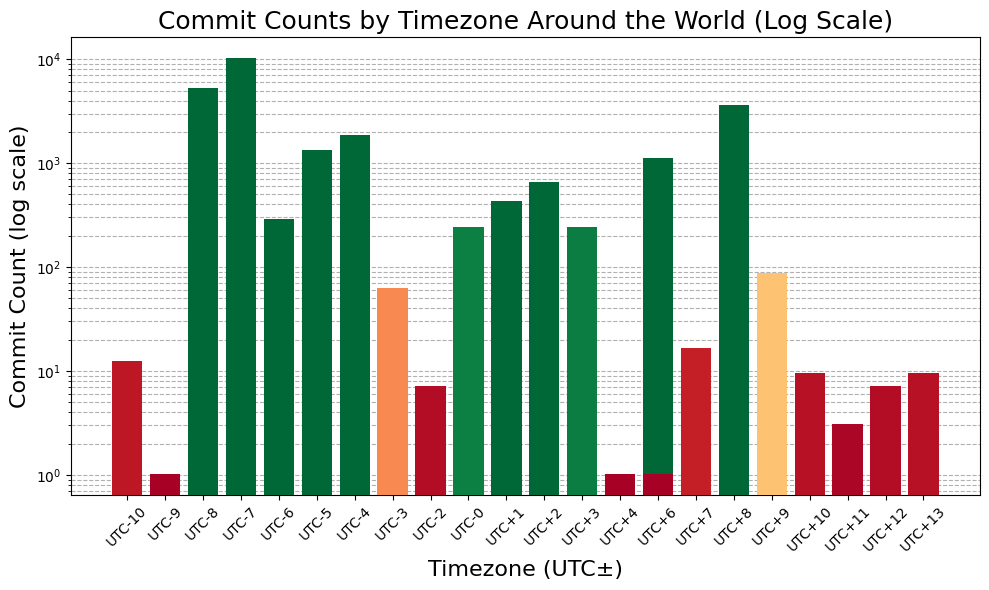

In [13]:
Reagent().boe_visualizations().show_percents_logarithmic_bar_chart(repo)

In [14]:
Reagent().composite_scores().nonadversarial_timezones(repo).df()

,timezone,percent_of_total_commits
0,-10.0,0.049
1,-9.0,0.004
2,-8.0,20.575
3,-7.0,40.050
4,-6.0,1.136
5,-5.0,5.235
6,-4.0,7.287
7,-3.0,0.244
8,-2.0,0.028
9,-0.0,0.953
